<a href="https://colab.research.google.com/github/ritwiks9635/Object_Recognition_And_Detection-/blob/main/%F0%9F%92%AB%F0%9F%9A%98Car%F0%9F%9A%98_Detection%F0%9F%95%B5%EF%B8%8F%E2%80%8D%E2%99%82%EF%B8%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **💫🚘Car🚘 Detection🕵️‍♂️**

In [1]:
#https://www.kaggle.com/datasets/sshikamaru/car-object-detection

In [ ]:
!unzip /content/https:/www.kaggle.com/datasets/sshikamaru/car-object-detection/car-object-detection.zip

In [4]:
import os
import cv2

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



import matplotlib.pyplot as plt

##**Data Preprocessing**

In [5]:
train_dir = "/content/data/training_images"
test_dir = "/content/data/testing_images"

print(os.listdir(train_dir)[:5])
print("Total Train images is :: ", len(os.listdir(train_dir)))
print("Total Test images is :: ", len(os.listdir(test_dir)))

['vid_4_16560.jpg', 'vid_4_29740.jpg', 'vid_4_26600.jpg', 'vid_4_19780.jpg', 'vid_4_16900.jpg']
Total Train images is ::  1001
Total Test images is ::  175


In [8]:
train_df = pd.read_csv("/content/data/train_solution_bounding_boxes (1).csv")
train_df.drop_duplicates(subset='image', inplace=True, ignore_index=True)
train_df.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [9]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop = True)
val_df = val_df.reset_index(drop = True)

##**Display Data**

In [10]:
def display_data(image, bbox_format = [], pred_bbox = [], norm = False):
    if norm:
        image = image * 255.0
        image = image.astype(np.uint8)

    if len(bbox_format) == 4:
        x_min, y_min, x_max, y_max = bbox_format
        image = cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 3)

    if len(pred_bbox) == 4:
        x_min, y_min, x_max, y_max = pred_bbox
        image = cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (255, 0, 0), 3)

    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])


def display_image_from_dir(path, bbox_format = [], dir = train_dir):
    image = cv2.imread(os.path.join(dir, path))
    display_data(image, bbox_format = bbox_format)


def display_image_from_DataFrame(df, dir = train_dir):
    display_image_from_dir(df["image"], bbox_format = (df["xmin"], df["ymin"], df["xmax"], df["ymax"]), dir = dir)



def display_image(df=train_df, n_items=3):
    plt.figure(figsize=(20, 10))

    # get 3 random entries and plot them in a 1x3 grid
    idx = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(idx):
        plt.subplot(1, n_items, pos + 1)
        display_image_from_DataFrame(df.loc[index, :])

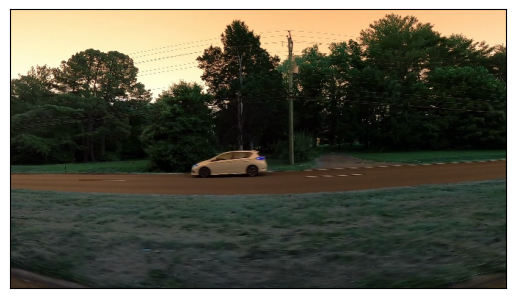

In [11]:
display_image_from_dir("vid_4_10040.jpg")

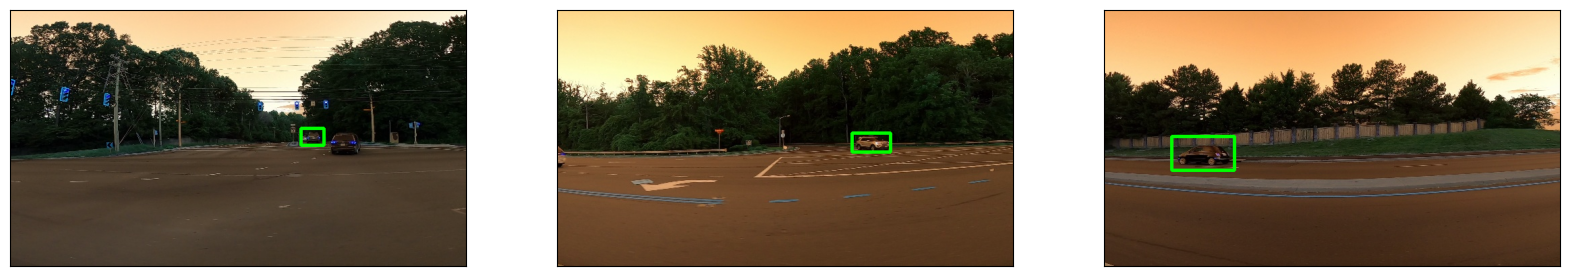

In [12]:
display_image()

##**Build custom data generator**

In [15]:
def data_generator(df, batch_size = 16, dir = train_dir):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
            idx = np.random.randint(0, df.shape[0])
            row = df.loc[idx]
            images[i] = cv2.imread(os.path.join(dir, str(row.image))) / 255.0
            bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {"image": images}, {"coords": bounding_box_coords}

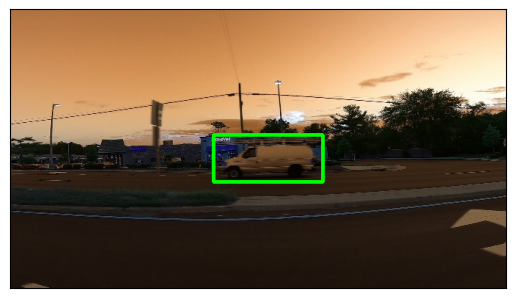

In [16]:
sample, label = next(data_generator(train_df, batch_size = 1))

image = sample["image"][0]
bbox_format = label["coords"][0]

display_data(image, bbox_format, norm = True)

In [17]:
train_generator = data_generator(train_df, batch_size=16, dir=train_dir)
val_generator = data_generator(val_df, batch_size=16, dir=train_dir)

##**Build Model**

In [24]:
input = layers.Input(shape=[380, 676, 3], name="image")

x = input

for i in range(10):
    n_filters = 2**(i + 3)

    res = x

    # Apply convolution, batch normalization, and activation
    x = layers.Conv2D(n_filters, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.MaxPooling2D(2, padding="same")(x)

    # Check if the shapes are different for residual connection
    if res.shape != x.shape:
        # Use a 1x1 Conv2D layer to adjust the shape of the residual connection
        res = layers.Conv2D(n_filters, kernel_size=1, strides=2, padding="same")(res)

    # Add the residual connection
    x = layers.add([x, res])

# Flatten the output and pass through Dense layers
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dropout(0.2)(x)

# Final output layer for bounding box coordinates
output = layers.Dense(4, name="coords")(x)

model = keras.Model(input, output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 380, 676, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 380, 676, 8)    │            224 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 380, 676, 8)    │             32 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 380, 676, 8)    │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_10          │ (None, 190, 338, 8)    │              0 │ activation_10[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 190, 338, 8)    │             32 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 190, 338, 8)    │              0 │ max_pooling2d_10[0][0… │
│                           │                        │                │ conv2d_21[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 190, 338, 16)   │          1,168 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 190, 338, 16)   │             64 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 190, 338, 16)   │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_11          │ (None, 95, 169, 16)    │              0 │ activation_11[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 95, 169, 16)    │            144 │ add_10[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 95, 169, 16)    │              0 │ max_pooling2d_11[0][0… │
│                           │                        │                │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 95, 169, 32)    │          4,640 │ add_11[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 95, 169, 32)    │            128 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 112,954,212 (430.89 MB)

 Trainable params: 112,937,844 (430.82 MB)

 Non-trainable params: 16,368 (63.94 KB)

In [28]:
model.compile(
    loss={"coords" : "mse"},
    optimizer = keras.optimizers.Adam(1e-4),
    metrics={"coords" : "accuracy"})

In [20]:
def model_pred(model, datagen):
    sample, label = next(datagen)

    image = sample["image"]
    bbox_format = label["coords"]

    pred_bbox = model.predict(image)[0]

    image = image[0]
    gt_bboxes = bbox_format[0]

    display_data(image, pred_bbox = pred_bbox, norm = True)


def display_pred(model):
    datagen = data_generator(train_df, batch_size=1, )

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        model_pred(model, datagen)
    plt.show()


class ShowImgCallbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        display_pred(self.model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


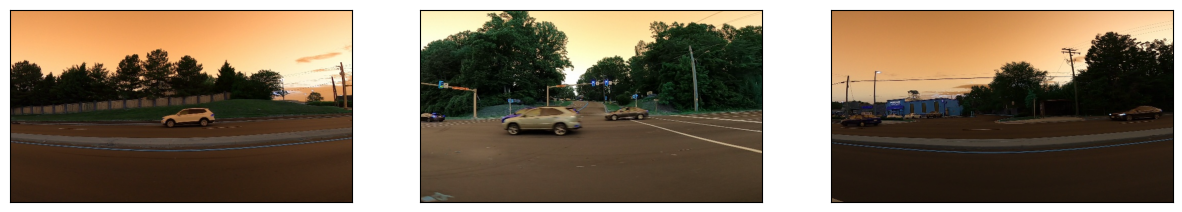

In [21]:
display_pred(model)

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(monitor = "loss", restore_best_weights = True)
checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model_E.keras", monitor='val_loss', save_best_only=True, mode='min', verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, verbose=1)

model.fit(
  train_generator,
  validation_data = val_generator,
  epochs=50,
  steps_per_epoch=len(train_df) // 16,
  validation_steps=len(val_df) // 16,
  callbacks=[ShowImgCallbacks(), checkpoint])

In [30]:
model.load_weights("best_model_E.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


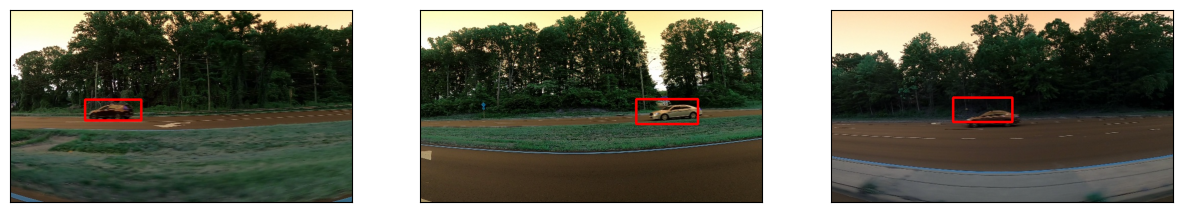

In [35]:
display_pred(model)

##**Video Generator**

In [ ]:
from tqdm import tqdm

test_dir = "/content/data/testing_images"

# Video file name
output_video_path = "object_detection_output.mp4"

frame_width, frame_height = 676, 380
fps = 3


def process_test_images(test_dir, model, output_video_path):

    test_images = os.listdir(test_dir)

    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define video codec
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

    for img_file in tqdm(test_images, desc="Processing test images"):
        # Read and pr
        img_path = os.path.join(test_dir, img_file)
        image = cv2.imread(img_path)
        image_resized = cv2.resize(image, (frame_width, frame_height)) / 255.0  # Resize and normalize

        # Model expects 4D input, so add a batch dimension
        input_image = np.expand_dims(image_resized, axis=0)

        # Predict bounding box
        pred_bbox = model.predict(input_image)[0]

        # Draw predicted bounding box on the image
        x_min, y_min, x_max, y_max = pred_bbox
        image_with_bbox = cv2.rectangle(image_resized * 255.0,
                                        (int(x_min), int(y_min)),
                                        (int(x_max), int(y_max)),
                                        (0, 255, 0), 3).astype(np.uint8)

        # Convert the image to the format suitable for video
        frame = cv2.cvtColor(image_with_bbox, cv2.COLOR_RGB2BGR)

        # Write the frame to the video
        video_writer.write(frame)

    # Release the video writer
    video_writer.release()

    print(f"Video saved at {output_video_path}")

# Call the function to generate the video
process_test_images(test_dir, model, output_video_path)